In [1]:
import geopandas as gpd
import pandas as pd
import fiona
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm import tqdm
from scipy.spatial import cKDTree
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
from rasterio.features import shapes
import rasterio
import numpy as np
import yaml
import os
import seaborn as sns

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)



Load, Reproject, Save Dam data

In [2]:
# Load the dams data and convert to GeoDataFrame
africa_dams = pd.read_csv(resolve_path(config['Africa_Dam_csv_path']))
geometry = [Point(xy) for xy in zip(africa_dams['Long__res_'], africa_dams['Lat__res_'])]
gdf_dams_deg = gpd.GeoDataFrame(africa_dams, geometry=geometry)
gdf_dams_deg = gdf_dams_deg.set_crs("EPSG:4326")  # Ensure the initial CRS is correct

# Reproject
gdf_dams = gdf_dams_deg.to_crs("EPSG:3857")

# Save reprojected dam data as .shp
gdf_dams.to_file(resolve_path(config['Africa_Dam_Reproj_shp_path']))

print(gdf_dams.head())


        Country  ISO  Long__res_  Lat__res_                          geometry
0      Zimbabwe  ZWE     30.4697   -19.9597  POINT (3391871.489 -2268257.449)
1         Benin  BEN      2.2500     8.1500     POINT (250468.854 910328.897)
2         Benin  BEN      1.8027    11.2077    POINT (200675.646 1255668.964)
3         Benin  BEN      2.2606     8.7959     POINT (251648.841 983023.981)
4  Burkina Faso  BFA     -3.2495    10.9542   POINT (-361732.685 1226913.346)


Load, Reproject, Save cropland data

In [3]:

# Load arid cropland tif
arid_cropland_tif_path = resolve_path(config['Arid_Cropland_tif_path'])

with rasterio.open(arid_cropland_tif_path) as src:
    original_crs = src.crs
    print(f"Original CRS: {original_crs}")

def reproject_raster(src_path, dst_path, dst_crs):
    with rasterio.open(src_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(dst_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

src_path = arid_cropland_tif_path
dst_path = resolve_path(config['Arid_Cropland_Reproj_tif_path'])
dst_crs = "EPSG:3857"

reproject_raster(src_path, dst_path, dst_crs)
print(f"Reprojected file saved to: {dst_path}")

with rasterio.open(dst_path) as src:
    new_crs = src.crs
    print(f"New CRS: {new_crs}")


Original CRS: EPSG:4326
Reprojected file saved to: /home/ermiller/Africa_Irrigation/Data/Processed/Arid_Cropland_Reproj.tif
New CRS: EPSG:3857


Load, Reproject, Save CPIS data

In [4]:
gdf_cpis_deg = gpd.read_file(resolve_path(config['Combined_CPIS_shp_path']))
print(gdf_cpis_deg.crs)
gdf_cpis_reproj = gdf_cpis_deg.to_crs("EPSG:3857")
print(gdf_cpis_reproj.crs)

gdf_cpis_reproj.to_file(resolve_path(config['Combined_CPIS_Reproj_shp_path']))

EPSG:4326
EPSG:3857


Load, Reproject, Save country data

In [5]:
# Load the country shapefile and reproject
gdf_countries_deg = gpd.read_file(resolve_path(config['Africa_Countries_shp_path']))
print(gdf_countries_deg.crs)
gdf_countries_reproj = gdf_countries_deg.to_crs("EPSG:3857")
print(gdf_countries_reproj.crs)

# Save the reprojected country data
gdf_countries_reproj.to_file(resolve_path(config['Africa_Countries_Reproj_shp_path']))

EPSG:4326
EPSG:3857


Sort it by country

In [6]:
# Load the reprojected country data
gdf_countries_reproj = gpd.read_file(resolve_path(config['Africa_Countries_Reproj_shp_path']))



# Load the repojected cropland data
cropland_reproj = rasterio.open(resolve_path(config['Arid_Cropland_Reproj_tif_path']))

# Function to extract raster values and their corresponding geometries
def extract_raster_values(raster):
    with rasterio.open(raster) as src:
        image = src.read(1)  # Read the first band
        results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) in enumerate(shapes(image, transform=src.transform))
        )
        geoms = list(results)
        gdf_raster = gpd.GeoDataFrame.from_features(geoms)
        gdf_raster.crs = src.crs
        return gdf_raster
    
gdf_cropland = extract_raster_values(resolve_path(config['Arid_Cropland_Reproj_tif_path']))

# Parse geometries and perform spatial join
gdf_cropland_points = gdf_cropland.explode().reset_index(drop=True)
gdf_cropland_joined = gpd.sjoin(gdf_cropland_points, gdf_countries_reproj, how = 'left', predicate = 'within')

# Keep only the 'geometry', 'raster_val', and 'ISO3' columns
gdf_cropland_joined = gdf_cropland_joined[['geometry', 'raster_val', 'ISO3']]

# Save the joined gdf
#gdf_cropland_joined.to_file(resolve_path(config['Arid_Cropland_by_Country_shp_path']))



# Load the reprojected dam data
gdf_dams_reproj = gpd.read_file(resolve_path(config['Africa_Dam_Reproj_shp_path']))
print(gdf_dams_reproj.crs)

# Perform spatial join
gdf_dams_joined = gpd.sjoin(gdf_dams_reproj, gdf_countries_reproj, how='left', predicate='within')
gdf_dams_joined = gdf_dams_joined[['geometry', 'ISO3']]

# Save joined dam data
#gdf_dams_joined.to_file(resolve_path(config['Africa_Dam_by_Country_shp_path']))



# Load the reprojected CPIS data
gdf_cpis_reproj = gpd.read_file(resolve_path(config['Combined_CPIS_Reproj_shp_path']))

# Perform spatial join
gdf_cpis_joined = gpd.sjoin(gdf_cpis_reproj, gdf_countries_reproj, how='left', predicate='within')
gdf_cpis_joined = gdf_cpis_joined[['geometry', 'ISO3']]

# Save the joined data
#gdf_cpis_joined.to_file(resolve_path(config['Combined_CPIS_by_Country_shp_path']))

/tmp/ipykernel_70503/1148209633.py:25: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_cropland_points = gdf_cropland.explode().reset_index(drop=True)


EPSG:3857


In [7]:
print(gdf_cropland_joined.head())
print(gdf_dams_joined.head())
print(gdf_cpis_joined.head())

                                            geometry  raster_val ISO3
0  POLYGON ((1076630.313 4488046.163, 1076630.313...       0.546  NaN
1  POLYGON ((1086271.202 4488046.163, 1086271.202...       0.831  NaN
2  POLYGON ((1038066.761 4478405.275, 1038066.761...       0.220  NaN
3  POLYGON ((1047707.649 4478405.275, 1047707.649...       0.062  NaN
4  POLYGON ((1066989.425 4478405.275, 1066989.425...       0.994  TUN
                           geometry ISO3
0  POINT (3391871.489 -2268257.449)  ZWE
1     POINT (250468.854 910328.897)  BEN
2    POINT (200675.646 1255668.964)  BEN
3     POINT (251648.841 983023.981)  BEN
4   POINT (-361732.685 1226913.346)  BFA
                                            geometry ISO3
0  POLYGON ((2158598.021 -4057555.506, 2158658.42...  ZAF
1  POLYGON ((2158740.433 -4056950.848, 2158788.75...  ZAF
2  POLYGON ((2286656.768 -4053677.724, 2286693.00...  ZAF
3  POLYGON ((2285644.300 -4053175.531, 2285704.69...  ZAF
4  POLYGON ((2184297.066 -4052314.792, 21843

Calculate Sum of Distances from each CPIS to point to the Nearest Dam

In [8]:
def sum_distance_to_nearest(src_gdf, target_gdf):
    src_points = np.array(list(src_gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
    target_points = np.array(list(target_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    if len(target_points) == 0:
        return 0  # Return 0 if there are no target points to avoid errors
    
    tree = cKDTree(target_points)
    dists, _ = tree.query(src_points, k=1)
    
    return np.sum(dists)

# Sum distances for CPIS to nearest dam
sum_distances_cpis = sum_distance_to_nearest(gdf_cpis_joined, gdf_dams_joined)

Calculate Average Distance of All Cropland to Nearest Dam for Each Country

In [9]:
def avg_distance_to_nearest_by_country(src_gdf, target_gdf):
    src_points = np.array(list(src_gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
    target_points = np.array(list(target_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    if len(target_points) == 0:
        return 0  # Return 0 if there are no target points to avoid errors

    tree = cKDTree(target_points)
    dists, _ = tree.query(src_points, k=1)
    
    return np.mean(dists)

avg_distances_cropland_by_country = gdf_cropland_joined.groupby('ISO3').apply(lambda group: avg_distance_to_nearest_by_country(group.drop(columns=['ISO3']), gdf_dams_joined[gdf_dams_joined['ISO3'] == group['ISO3'].iloc[0]]))


/tmp/ipykernel_70503/267574641.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_distances_cropland_by_country = gdf_cropland_joined.groupby('ISO3').apply(lambda group: avg_distance_to_nearest_by_country(group.drop(columns=['ISO3']), gdf_dams_joined[gdf_dams_joined['ISO3'] == group['ISO3'].iloc[0]]))


Calculate the Targeting Ratio

In [10]:
# Count the number of CPIS in each country
cpis_count_by_country = gdf_cpis_joined['ISO3'].value_counts()

# Ensure that both series contain the same countries
common_iso3 = cpis_count_by_country.index.intersection(avg_distances_cropland_by_country.index)

# Calculate the denominator
denominator = sum(cpis_count_by_country[iso3] * avg_distances_cropland_by_country[iso3] for iso3 in common_iso3)

# Compute the targeting ratio
overall_targeting_ratio = sum_distances_cpis / denominator
print(f"Targeting Ratio: {overall_targeting_ratio}")


Targeting Ratio: 1.314889236053239


Calculate Targeting Ratio at Different Thresholds

/tmp/ipykernel_70503/3809230206.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_distances_cropland_by_country = gdf_cropland_joined.groupby('ISO3', group_keys=False).apply(avg_distance_to_nearest)
/tmp/ipykernel_70503/3809230206.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_distances_cropland_by_country = gdf_cropland_joined.groupby('ISO3', group_keys=False).apply(avg_distance_to_nearest

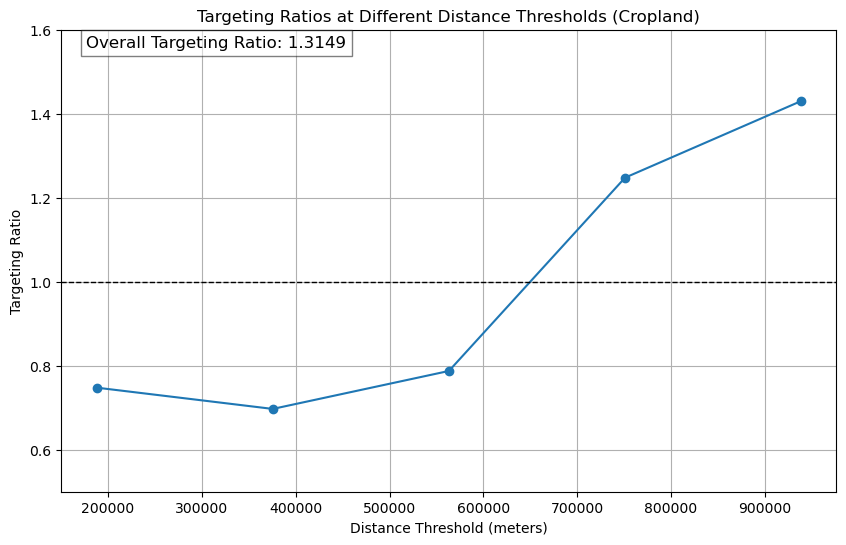

In [11]:
# Function to calculate distances to nearest target
def calculate_distances(src_gdf, target_gdf):
    src_centroids = np.array(list(src_gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
    target_points = np.array(list(target_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    if target_points.shape[0] == 0 or src_centroids.shape[0] == 0:
        return np.array([])  # Return empty array if there are no points
    
    tree = cKDTree(target_points)
    dists, _ = tree.query(src_centroids, k=1)
    
    return dists


# Calculate distances for CPIS to nearest dam
distances_cpis_to_dams = calculate_distances(gdf_cpis_joined, gdf_dams_joined)

# Compute the maximum distance
max_distance = np.max(distances_cpis_to_dams)

# Define thresholds by splitting the maximum distance into 5 intervals
thresholds = np.linspace(0, max_distance, 6)[1:]  # Create 5 thresholds

# Calculate the targeting ratio for each threshold
targeting_ratios = []

for threshold in thresholds:
    # Filter distances for CPIS to nearest dam
    filtered_distances_cpis = distances_cpis_to_dams[distances_cpis_to_dams <= threshold]
    sum_distances_cpis = np.sum(filtered_distances_cpis)
    
    # Calculate average distances of cropland to nearest dam by country
    def avg_distance_to_nearest(group):
        distances = calculate_distances(group, gdf_dams_joined[gdf_dams_joined['ISO3'] == group['ISO3'].iloc[0]])
        filtered_distances = distances[distances <= threshold]
        if len(filtered_distances) > 0:
            return np.mean(filtered_distances)
        else:
            return np.nan

    # Exclude grouping columns
    avg_distances_cropland_by_country = gdf_cropland_joined.groupby('ISO3', group_keys=False).apply(avg_distance_to_nearest)
    
    # Filter out NaNs
    avg_distances_cropland_by_country = avg_distances_cropland_by_country.dropna()
    
    # Count the number of CPIS in each country
    cpis_count_by_country = gdf_cpis_joined['ISO3'].value_counts()
    
    # Ensure that both series contain the same countries
    common_iso3 = cpis_count_by_country.index.intersection(avg_distances_cropland_by_country.index)
    
    # Calculate the denominator
    denominator = sum(cpis_count_by_country[iso3] * avg_distances_cropland_by_country[iso3] for iso3 in common_iso3)
    
    # Compute the targeting ratio
    targeting_ratio = sum_distances_cpis / denominator if denominator != 0 else np.nan
    targeting_ratios.append(targeting_ratio)


# Plot targeting ratios at different thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, targeting_ratios, marker='o', linestyle='-')
plt.title('Targeting Ratios at Different Distance Thresholds (Cropland)')
plt.xlabel('Distance Threshold (meters)')
plt.ylabel('Targeting Ratio')
plt.ylim(0.5, 1.6)  # Set y-axis limits
plt.grid(True)

# Add text box with overall targeting ratio
textstr = f'Overall Targeting Ratio: {overall_targeting_ratio:.4f}'
plt.gcf().text(0.15, 0.85, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Add horizontal line at y=1
plt.axhline(y=1, color='black', linestyle='--', linewidth=1)

plt.show()


/tmp/ipykernel_70503/1268797273.py:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


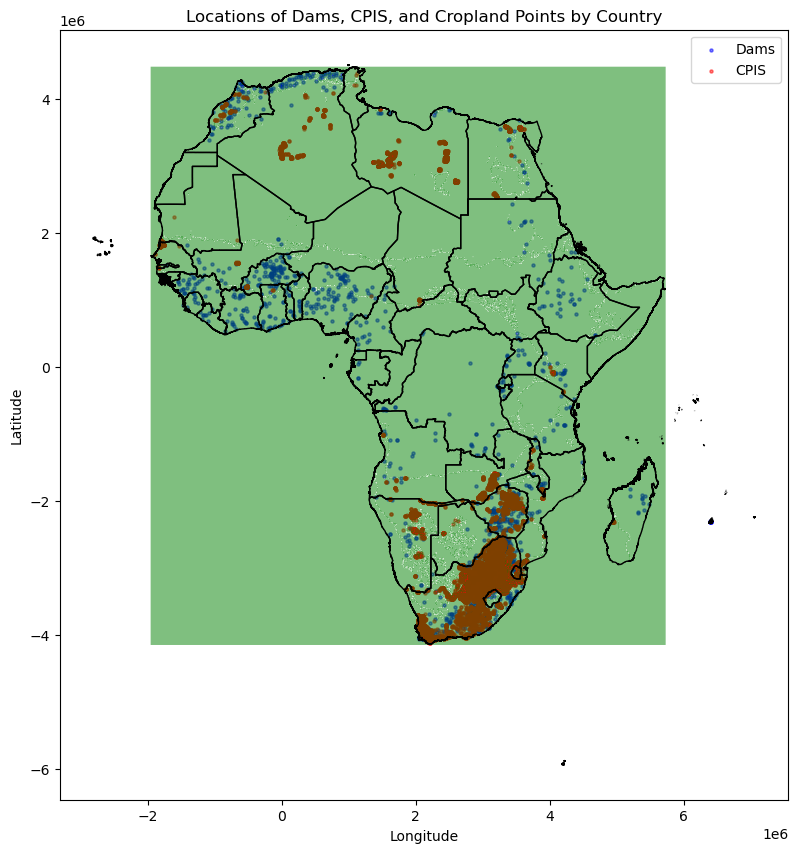

In [12]:
# Plot dams, CPIS, and cropland points
fig, ax = plt.subplots(figsize=(15, 10))

# Plot country boundaries
gdf_countries_reproj.boundary.plot(ax=ax, linewidth=1, color='black')

# Plot dams
gdf_dams_joined.plot(ax=ax, markersize=5, color='blue', alpha=0.5, label='Dams')

# Plot CPIS
gdf_cpis_joined.centroid.plot(ax=ax, markersize=5, color='red', alpha=0.5, label='CPIS')

# Plot cropland points
gdf_cropland_joined.plot(ax=ax, markersize=5, color='green', alpha=0.5, label='Cropland')

plt.legend()
plt.title('Locations of Dams, CPIS, and Cropland Points by Country')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


##### Consider Distribution of Distance Data

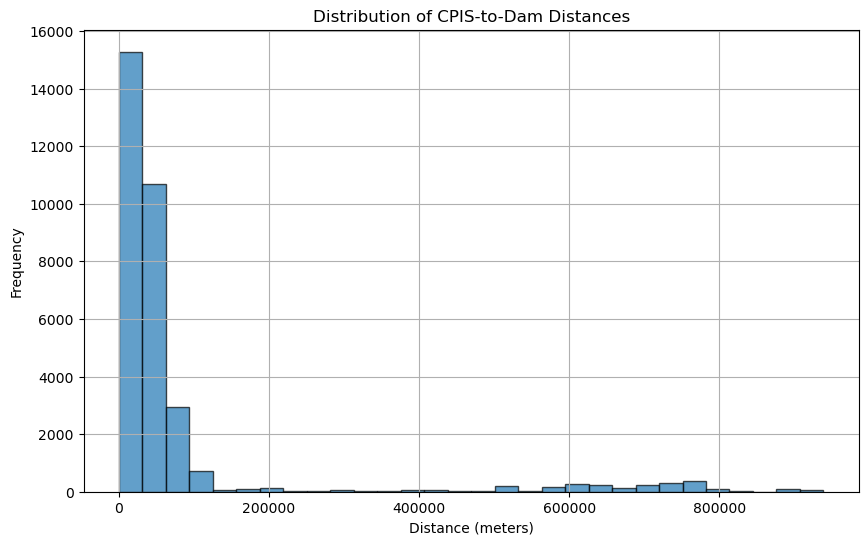

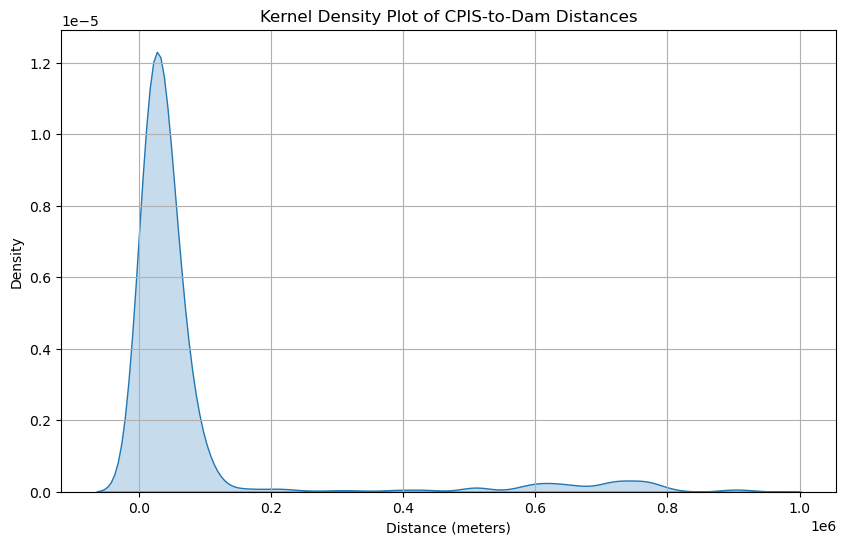

In [13]:

# Histogram of CPIS-to-dam distances
plt.figure(figsize=(10, 6))
plt.hist(distances_cpis_to_dams, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of CPIS-to-Dam Distances')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Kernel Density Plot of CPIS-to-dam distances
plt.figure(figsize=(10, 6))
sns.kdeplot(distances_cpis_to_dams, fill=True)
plt.title('Kernel Density Plot of CPIS-to-Dam Distances')
plt.xlabel('Distance (meters)')
plt.ylabel('Density')
plt.grid(True)
plt.show()


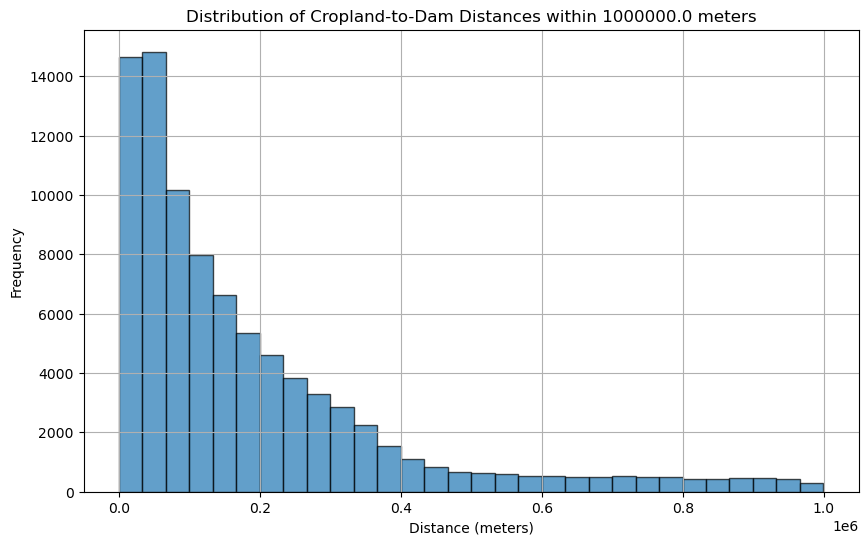

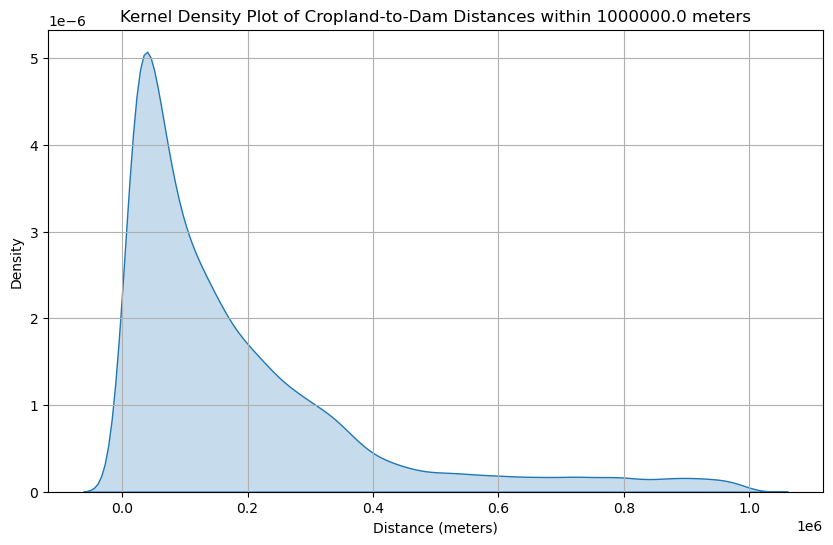

In [14]:
threshold = 1.0e6
# Filter distances for cropland to nearest dam within the threshold
cropland_distances = calculate_distances(gdf_cropland_joined, gdf_dams_joined)
filtered_cropland_distances = cropland_distances[cropland_distances <= threshold]

# Histogram of cropland-to-dam distances
plt.figure(figsize=(10, 6))
plt.hist(filtered_cropland_distances, bins=30, edgecolor='black', alpha=0.7)
plt.title(f'Distribution of Cropland-to-Dam Distances within {threshold} meters')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Kernel Density Plot of cropland-to-dam distances within the threshold
plt.figure(figsize=(10, 6))
sns.kdeplot(filtered_cropland_distances, fill=True)
plt.title(f'Kernel Density Plot of Cropland-to-Dam Distances within {threshold} meters')
plt.xlabel('Distance (meters)')
plt.ylabel('Density')
plt.grid(True)
plt.show()
